# 딥러닝 MainQuest(09) - 데싸 4기 손다혜

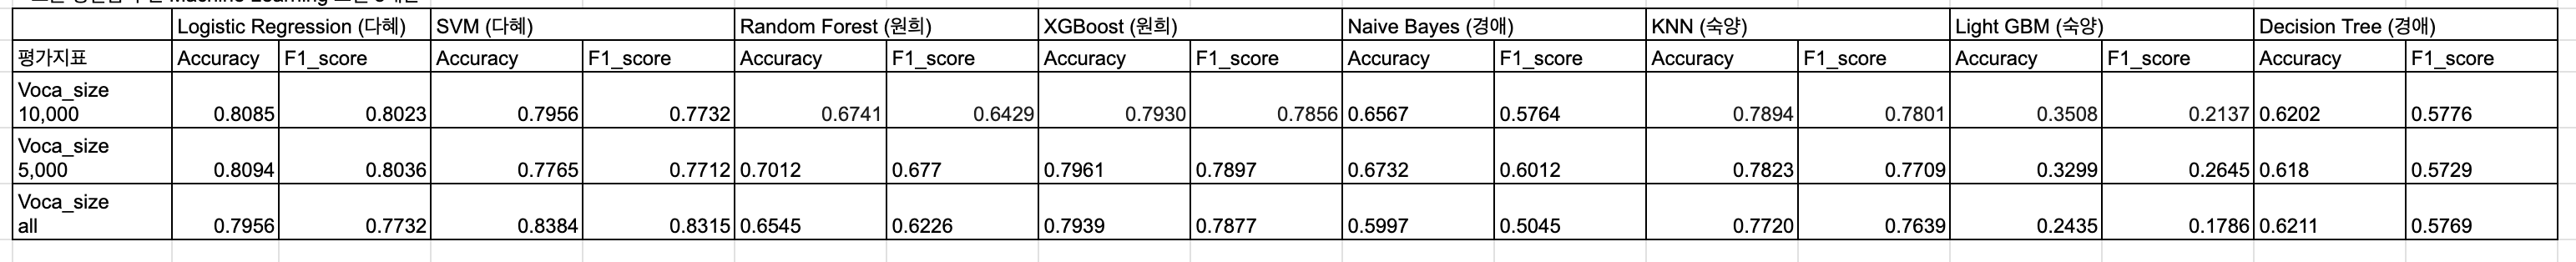

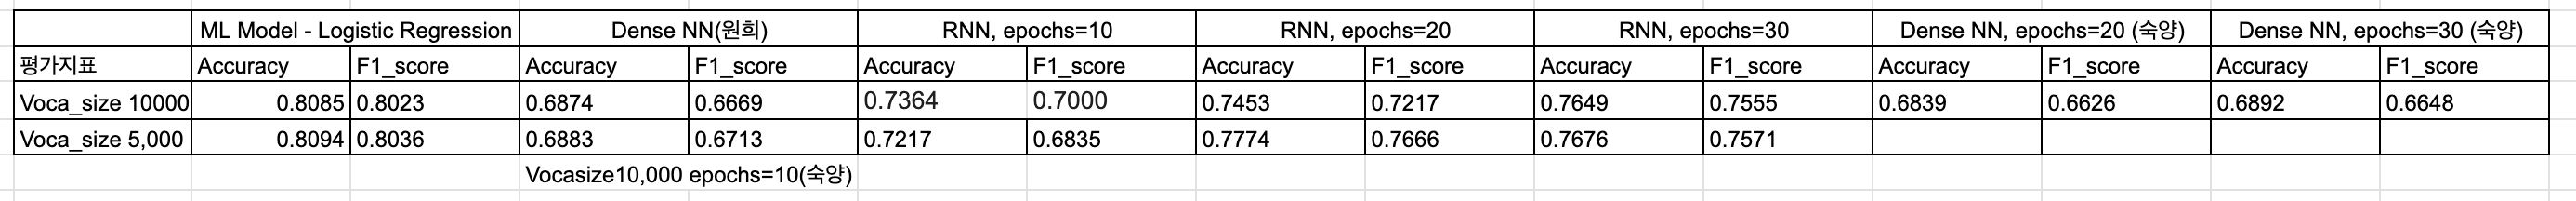

# 생각보다 모델 돌아가는데 오래 걸리지 않았다.
# 퍼실님께서 예방주사를 놓으신걸까?

제일 좋은 모델 : Voca_size 10,000과 5000에서는 Logistic Regression  
=> voca_size all 중에서는 SVM 성능이 가장 뛰어나다.  

결론 : Voca_size all 이고, SVM 모델을 사용했을 때 가장 결과가 좋았다.


# 데이터셋 만들기

In [1]:
!pip install gensim

In [2]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 데이터 준비
## index -> text
## DTM , TF-idf 학습데이터 준비
## W2V 학습데이터 준비

In [3]:
# 이부분에있는 num_words를 5000과 다른방법으로 바꿔보세요~

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2) ##

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [6]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [7]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


In [8]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [9]:
x_train[3]

"<sos> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely <unk> borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in <unk> financial eligibility standards indicated as many as one half of <unk> borrowers who received new loans from the agency in 1986 would be <unk> under the proposed system the agency has proposed evaluating <unk> credit using a variety of financial ratios instead of relying solely on <unk> ability senate agriculture committee chairman patrick leahy d vt <unk> the proposed eligibility changes telling <unk> administrator <unk> clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmers' lender of last re

In [10]:
# 벡터화 W2V방법
from gensim.models import Word2Vec

# 우선 문장을 토큰화 시킵시다 띄어쓰기 기반으로 해볼게요! -> # 위에서 DTM만들때는 왜 안해줬냐! -> CountVectorizer에서 띄어쓰기 기반 토큰화가 내장되있음
x_train_tokenized = [sentence.split() for sentence in x_train]
x_test_tokenized = [sentence.split() for sentence in x_test]

# vector사이즈를 늘리거나 줄여보세요 아마 512 가장많이쓰이는 방식
model = Word2Vec(sentences = x_train_tokenized, vector_size = 256, window = 5, min_count = 5, workers = 4, sg = 0)
print("모델 학습 완료!")

모델 학습 완료!


In [11]:
# W2V이 잘되었는지 확인 -> 여차저차 되긴한것같다
model_result = model.wv.most_similar('man')
print(model_result)

[('ontario', 0.816385805606842), ('gordon', 0.8136347532272339), ('glenn', 0.8043506145477295), ('adams', 0.7977473735809326), ('iowa', 0.7955185770988464), ('noranda', 0.786345899105072), ('constructions', 0.7853613495826721), ('elevator', 0.7849261164665222), ('crystal', 0.7819560766220093), ('erie', 0.7816401720046997)]


In [12]:
# 학습된 Word2Vec 모델
w2v_model = model

# 각 문장을 벡터화 시키는 코드
def vectorize_sentence(sentence, model, max_len):
    vecs = []
    for word in sentence:
        if word in model.wv:
            vecs.append(model.wv[word])
        else:
            vecs.append(np.zeros(model.vector_size))
    # Padding
    if len(vecs) < max_len:
        vecs += [np.zeros(model.vector_size)] * (max_len - len(vecs))
    else:
        vecs = vecs[:max_len]
    return np.array(vecs)


# 최대 문장길이를 잘 잡아주세요
x_train_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_train_tokenized])
x_test_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_test_tokenized])




In [13]:
x_train_w2v.shape

(8982, 100, 256)

In [14]:
x_test_w2v.shape

(2246, 100, 256)

# 모델 정의 및 실험
머신러닝 실험은 저번 코드를 참고해주세요~

두번째 실험에 대해서만 다루겠습니다

In [17]:
# Logistic Regression
# voca_size : 10000

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(x_train_tfidf, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [20]:
# 예측
predicted = lr.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.8085
✅ F1-score : 0.8023


In [21]:
# 데이터를 단어단위에서 문장단위로 바꿔줘야합니다.. ML은 2차원데이터만 받을수있기때문
# 문장에 대해서 토큰들의 벡터를 평균을 취해줍니다.

# Word2Vec 임베딩 시퀀스: (8982, 100, 256)
x_w2v_seq_train = x_train_w2v
x_w2v_seq_test = x_test_w2v
# 평균 풀링 → (8982, 256)
x_w2v_avg_train = np.mean(x_w2v_seq_train, axis=1)
x_w2v_avg_test = np.mean(x_w2v_seq_test, axis=1)
print(x_w2v_avg_train.shape)  # (8982, 256)

(8982, 256)


In [22]:
# Logistic Regression
# voca_size : 5000

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=5000, penalty='l2', max_iter=3000)
lr.fit(x_train_tfidf, y_train)

LogisticRegression(C=5000, max_iter=3000)

In [23]:
# 예측
predicted = lr.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.8094
✅ F1-score : 0.8036


In [25]:
# Logistic Regression
# voca_size : NaN (All words)

from sklearn.linear_model import LogisticRegression

# C 파라미터에 적절한 양수 값 할당 (예: 이전 실험에서 사용한 값 또는 다른 값)
lr = LogisticRegression(C=1.0, penalty='l2', max_iter=3000) # 예시로 1.0을 사용
lr.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=3000)

In [26]:
# 예측
predicted = lr.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7956
✅ F1-score : 0.7732


In [26]:
# SVM
# voca_size : 10000

from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=10000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(x_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=10000, dual=False, max_iter=3000, penalty='l1')

In [27]:
# 예측
predicted = lsvc.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7689
✅ F1-score : 0.7661


In [15]:
# SVM
# voca_size : 5000

from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=5000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(x_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=5000, dual=False, max_iter=3000, penalty='l1')

In [22]:
# 예측
predicted = lsvc.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7765
✅ F1-score : 0.7712


In [24]:
# SVM
# voca_size : NaN (All words)

from sklearn.svm import LinearSVC

# C 파라미터는 NaN과 직접적인 관련이 없으며, 적절한 값을 사용해야 합니다.
# 여기서는 예시로 C=1.0을 사용하거나, 이전 실험에서 좋은 결과를 보였던 C 값을 사용해 보세요.
lsvc = LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False) # 예시로 C=1.0 사용
lsvc.fit(x_train_tfidf, y_train)

LinearSVC(dual=False, max_iter=3000, penalty='l1')

In [25]:
# 예측
predicted = lsvc.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.8384
✅ F1-score : 0.8315


# Dense NN 딥러닝 모델

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout


dense_model = Sequential([
    Flatten(input_shape=(100, 256)),  # (seq_len, embedding_dim)
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')   # 클래스 수에 맞게 조정 46개로 맞춰주세요!
])

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,179,310 (50.28 MB)

 Trainable params: 13,179,310 (50.28 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# 시간이 좀 걸립니다! 한 20분정도..
dense_model.fit(x_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5282 - loss: 2.1714 - val_accuracy: 0.6694 - val_loss: 1.4439
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6903 - loss: 1.3135 - val_accuracy: 0.6728 - val_loss: 1.4057
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7472 - loss: 1.0569 - val_accuracy: 0.6878 - val_loss: 1.3945
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7765 - loss: 0.9103 - val_accuracy: 0.6906 - val_loss: 1.4046
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8187 - loss: 0.7135 - val_accuracy: 0.6900 - val_loss: 1.5251
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8487 - loss: 0.6325 - val_accuracy: 0.6900 - val_loss: 1.5075
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8596 - loss: 0.5514 - val_accuracy: 0.6934 - val_loss: 1.5957
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8804 - loss: 0.5178 - val_accuracy:

In [30]:


y_pred_proba = dense_model.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✅ Accuracy: 0.6785
✅ F1-score: 0.6555


# RNN 딥러닝 모델

In [31]:
# rnn 시계열 특징 데이터 특화 모델

rnn_model = Sequential([
    LSTM(128, input_shape=(100, 256)),  # (seq_len, embedding_dim)
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')   # 클래스 수에 맞게 조정 46개로 맞춰주세요~
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,366 (813.93 KB)

 Trainable params: 208,366 (813.93 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# 시간이 좀 걸립니다! 한 20분정도
rnn_model.fit(x_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3949 - loss: 2.5285 - val_accuracy: 0.6071 - val_loss: 1.6879
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5925 - loss: 1.6677 - val_accuracy: 0.6489 - val_loss: 1.5023
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6287 - loss: 1.5361 - val_accuracy: 0.6516 - val_loss: 1.4440
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6629 - loss: 1.3951 - val_accuracy: 0.7028 - val_loss: 1.2713
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6911 - loss: 1.2832 - val_accuracy: 0.7190 - val_loss: 1.1916
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7143 - loss: 1.1788 - val_accuracy: 0.7279 - val_loss: 1.1408
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7228 - loss: 1.1155 - val_accuracy: 0.7329 - val_loss: 1.1124
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7325 - loss: 1.0568 - val_accuracy

# 로스가 떨어지는 폭을 보아하니 좀더 돌리면 점수가 더 높게 나올것같습니다!

여기까지 실험하고 시간이 좀 남으시는 분들만 실험해보시길

In [33]:

y_pred_proba = rnn_model.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✅ Accuracy: 0.7329
✅ F1-score: 0.6957
